In [105]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import os
import statistics

In [2]:
work_dir = os.getcwd()
work_dir

'C:\\Users\\Evan\\Documents\\GitHub\\FuturesStrategy'

## Read the Data

In [3]:
Data_path = os.path.join(work_dir, 'Data')
TX = pd.read_csv(os.path.join(Data_path, 'TX.csv'), encoding = 'cp950')
OI = pd.read_csv(os.path.join(Data_path, 'MTXOpenInterest.csv'), encoding = 'cp950')
TX['日期'] = pd.to_datetime(TX['日期']) 
OI['日期'] = pd.to_datetime(OI['日期']) 

In [4]:
TX.shape

(4116, 8)

In [5]:
OI.shape

(735, 4)

In [6]:
OI.tail()

,日期,自營商,外資,投信
730,2020-04-16,1413602,1575209,42234
731,2020-04-17,2244324,-367902,42780
732,2020-04-20,1756390,-2425912,34568
733,2020-04-21,1538302,-2029498,33647
734,2020-04-22,914106,-2022450,32710


 Aggregating the open interest of Institutional investors

In [7]:
OI['三大法人總和'] = OI['自營商'] + OI['外資'] + OI['投信']

In [8]:
OI.tail()

,日期,自營商,外資,投信,三大法人總和
730,2020-04-16,1413602,1575209,42234,3031045
731,2020-04-17,2244324,-367902,42780,1919202
732,2020-04-20,1756390,-2425912,34568,-634954
733,2020-04-21,1538302,-2029498,33647,-457549
734,2020-04-22,914106,-2022450,32710,-1075634


## We take out the closest delivery TX as out underlying.  小台近日

In [9]:
TX00 = TX.drop_duplicates(subset = ['日期'], keep = 'first').reset_index(drop=True)

In [10]:
TX00.head()

,期貨名稱,日期,到期月,開盤價,收盤價,每日結算價,未平倉合約數,無風險利率
0,TX201705 台指 2017/05,2017-04-24,May-17,9747.0,9705.0,9706,86630,1.045
1,TX201705 台指 2017/05,2017-04-25,May-17,9746.0,9813.0,9814,88368,1.045
2,TX201705 台指 2017/05,2017-04-26,May-17,9855.0,9841.0,9842,88047,1.045
3,TX201705 台指 2017/05,2017-04-27,May-17,9829.0,9839.0,9838,88742,1.045
4,TX201705 台指 2017/05,2017-04-28,May-17,9847.0,9857.0,9856,88286,1.045


In [11]:
TX00['CC'] = TX00['每日結算價'].pct_change()
TX00['OC'] = (TX00['收盤價'] - TX00['開盤價'])/TX00['開盤價']

In [12]:
TX00.head()

,期貨名稱,日期,到期月,開盤價,收盤價,每日結算價,未平倉合約數,無風險利率,CC,OC
0,TX201705 台指 2017/05,2017-04-24,May-17,9747.0,9705.0,9706,86630,1.045,NaN,-0.004309
1,TX201705 台指 2017/05,2017-04-25,May-17,9746.0,9813.0,9814,88368,1.045,0.011127,0.006875
2,TX201705 台指 2017/05,2017-04-26,May-17,9855.0,9841.0,9842,88047,1.045,0.002853,-0.001421
3,TX201705 台指 2017/05,2017-04-27,May-17,9829.0,9839.0,9838,88742,1.045,-0.000406,0.001017
4,TX201705 台指 2017/05,2017-04-28,May-17,9847.0,9857.0,9856,88286,1.045,0.001830,0.001016


In [13]:
TX00.dtypes

期貨名稱              object
日期        datetime64[ns]
到期月               object
開盤價              float64
收盤價              float64
每日結算價              int64
未平倉合約數             int64
無風險利率            float64
CC               float64
OC               float64
dtype: object

## Show the TX first 

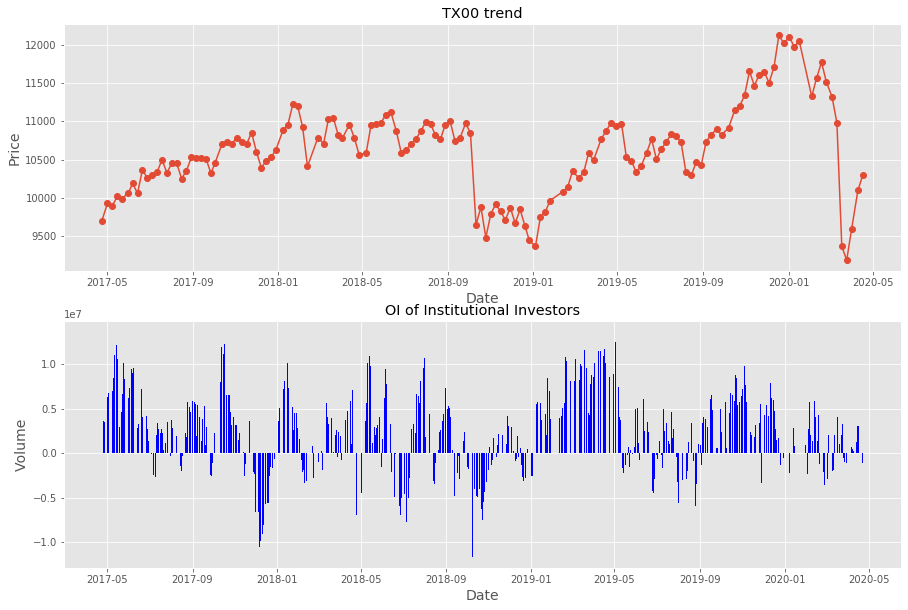

In [14]:
date = TX00.iloc[::5, :]['日期']
closePrice = TX00.iloc[::5, :]['每日結算價']
OIII = OI.iloc[:, :]['三大法人總和']
date1 = OI.iloc[:, :]['日期']

plt.style.use('ggplot')
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.plot(date, closePrice, marker='o')
title_name1 = "TX00 trend" 
plt.title(title_name1)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)

plt.subplot(212)
plt.bar(date1, OIII, color = 'blue')
title_name2 = "OI of Institutional Investors"
plt.title(title_name2)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volume', fontsize=14)

plt.savefig(os.path.join(work_dir, 'Graph', title_name1 + title_name2))
plt.show()

## Run the correlation between MTXOI and TX

In [15]:
dailyMTXR = TX00['每日結算價'].pct_change()

In [16]:
dailyMTXR.head()

0         NaN
1    0.011127
2    0.002853
3   -0.000406
4    0.001830
Name: 每日結算價, dtype: float64

In [37]:
dailyOIchange = OI['三大法人總和'] - OI['三大法人總和'].shift(1) # today's OI aggregation minus yesterday's OI aggregation

In [41]:
dailyOIchange.head()

0          NaN
1    3332060.0
2     -59445.0
3    -143837.0
4     589032.0
Name: 三大法人總和, dtype: float64

In [19]:
np.corrcoef(dailyMTXR[1:], dailyOIchange[1:])

array([[1.        , 0.46794229],
       [0.46794229, 1.        ]])

The correlation between the TX return and OIchange is 0.47

# Description of the Performance

In [196]:
def get_HPR(pnl):
    days = len(pnl)
    years = days/252
    HPR = pnl[days-1]/100 - 1 
    return HPR

In [197]:
def get_APR(pnl): 
    days = len(pnl)
    years = days/252
    HPR = pnl[days-1]/100 - 1
    APR = (HPR + 1)**(1/years) - 1 # annulized the cumulative returns
    return APR

In [203]:
def get_Sharp(pnl, rf): 
    Std = pnl.pct_change().std() # the standard deviation of the return 
    AStd = Std * np.sqrt(252) # annulized the std
    SharpRatio = round((APR - rf) / AStd, 4)
    return SharpRatio

In [ ]:
def get_mdd(pnl):
    dd = pnl - pnl.cummax()
    dd_pct = dd/pnl.cummax()
    mdd = round(dd_pct.min(), 2)
    return mdd

In [183]:
def print_performance(pnl, rf = 0.01045):
    days = len(pnl)
    years = days/252
    HPR = pnl[days-1]/100 - 1 # the cumulative returns
    APR = (HPR + 1)**(1/years) - 1 # annulized the cumulative returns
    Std = pnl.pct_change().std() # the standard deviation of the return 
    AStd = Std * np.sqrt(252) # annulized the std
    SharpRatio = round((APR - rf) / AStd, 4)
    dd = pnl - pnl.cummax()
    dd_pct = dd/pnl.cummax()
    mdd = round(dd_pct.min(), 2)
    
    print("HPR: " + str(HPR)) 
    print("APR: " + str(APR)) 
    print("Sharp Ratio: " + str(SharpRatio))   
    print("mdd: " + str(mdd))

In [208]:
def plot_performance(pnl, date, title_name):
    
    dd = pnl - pnl.cummax()
    dd_pct = dd/pnl.cummax()
    mdd = round(dd_pct.min(), 2)
    
    plt.style.use('ggplot')
    plt.figure(figsize=(15,10))
    plt.grid()
    plt.subplot(211)
    plt.plot(date, pnl, color = 'Red')
    plt.title(title_name)
    plt.xlabel('Days', fontsize=14)
    plt.ylabel('Price', fontsize=14)

    plt.subplot(212)
    plt.bar(date, dd_pct, color = 'blue')
    plt.xlabel('Days', fontsize=14)
    plt.ylabel('Drawdown (%)', fontsize=14)

    plt.savefig(os.path.join(work_dir, 'Graph', title_name))
    plt.show()

# Strategy Development 

* Strategy1: Buy and Hold
* Strategy2: 
      - Buy @ OpenPrice_T+1 and offset at the @ closePrice_T+1 if the dailyOIchange is positive;  
      - Sell @ OpenPrice_T+1 and offset at the @ closePrice_T+1 if the dailyOIchange is negative
* Strategy3: Buy

In [102]:
def buyandhold(data): 
    length = len(data)
    idx = [True] * length 
    
    data['LS'] = idx
    data['pnl'] = 100 * (1 + data['LS'] * data['CC']).cumprod()
    
    return data['pnl']

In [192]:
pnl = buyandhold(TX00)

In [193]:
pnl

0             NaN
1      101.112714
2      101.401195
3      101.359984
4      101.545436
          ...    
730    106.130229
731    108.829590
732    107.922934
733    105.048424
734    105.316299
Name: pnl, Length: 735, dtype: float64

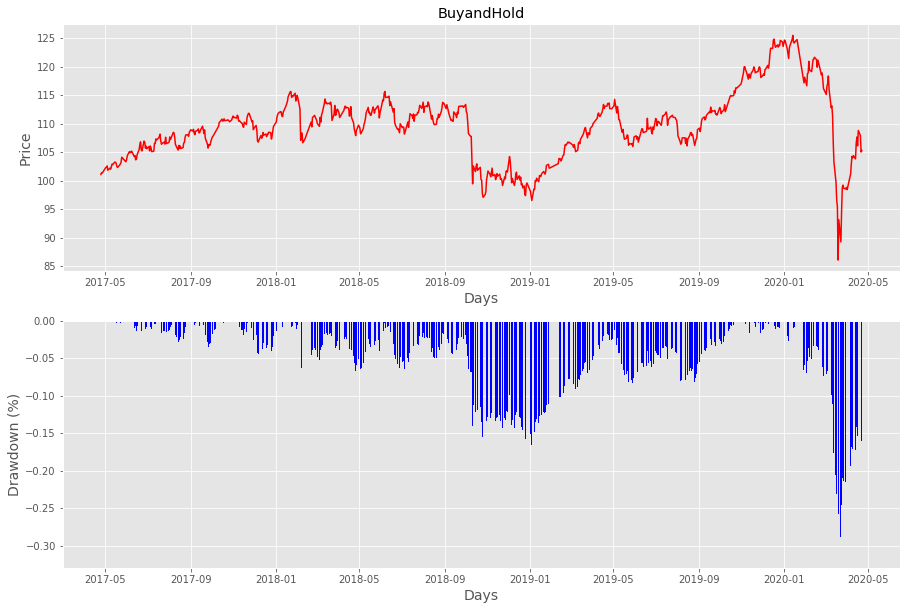

In [209]:
plot_performance(pnl, date = date1, title_name = 'BuyandHold')

In [221]:
print_performance(pnl, rf = 0.01045)

HPR: 0.053162991963733086
APR: 0.017917951862802983
Sharp Ratio: 0.0434
mdd: -0.31


In [222]:
def strategy2_LS(data): 
    # Buy if the dailyOIchange is positive, Sell if the dailyOIchange is negative
    length = len(data)
    idx = [0] * length
    for i in range(0, len(dailyOIchange)):
        if dailyOIchange[i] > 0: 
            idx[i] = 1
        elif dailyOIchange[i] < 0: 
            idx[i] = -1
        else: 
            idx[i] = 0

    data['LS'] = idx
    data['pnl'] = 100 * (1 + data['LS'].shift(1) * data['OC']).cumprod()
    
    return data['pnl']

In [223]:
pnl = strategy2_LS(TX00)

In [ ]:
plot_performance(pnl, , date = date1, title_name = 'Strategy2')

In [184]:
print_performance(pnl)

HPR: 0.2135494791725967
APR: 0.06861117189067811
Sharp Ratio: 0.5171
mdd: -0.16
